### Computer Model Distributions Notebook

 This notebook is used to generate a distribution plot for trained models.

In [3]:
import os
import argparse
import shutil
import numpy as np
import imageio
import time
import torch
import sys
import math
from torch.utils.data import DataLoader
from tqdm import tqdm
sys.path.insert(0, "../../SemanticStyleGAN")
from models import make_model
from visualize.utils import generate
from utils.dataset import MaskDataset
import matplotlib.pyplot as plt

In [4]:


## This function is different than the one in Control class in that takes image as 4 dimensional input
def from_rgb_to_label(image, color_map):
    color_map_sum = {}
    for c in color_map:
        color_map_sum[c] = sum(color_map[c])
    image_tensor = torch.tensor(image).to(float)
    image_summed = torch.sum(image_tensor, dim=3)
    for index in color_map_sum:
        image_summed=torch.where(image_summed==color_map_sum[index],torch.tensor(index),image_summed)
    return image_summed

In [5]:
def generate_model_dist_plot(ckpt,color_map,labels,samples=10,truncation_mean=10_000,batch=8,save_dir=None):
    device="cpu"
    ckpt = torch.load(ckpt, map_location=torch.device("cpu"))
    model = make_model(ckpt["args"])
    model.to(device)
    model.eval()
    model.load_state_dict(ckpt["g_ema"])
    mean_latent = model.style(
        torch.randn(truncation_mean, model.style_dim, device=device)
    ).mean(0)

    print("Generating images ...")
    start_time = time.time()
    class_dist = np.zeros(len(color_map))
    with torch.no_grad():
        for i in range(math.ceil(samples/batch)):
            print(f"{(i/math.ceil(samples/batch)*100)}% of data got generated")
            styles = model.style(
                torch.randn(batch, model.style_dim, device=device)
            )
            _, segs = generate(
                model, styles, mean_latent=mean_latent, batch_size=batch
            )
            segs_converted = from_rgb_to_label(segs,color_map)
            img_dist = torch.bincount(segs_converted.int().flatten(),minlength=len(color_map))
            class_dist = torch.add(torch.tensor(class_dist),img_dist)

    class_dist = class_dist/class_dist.sum()## Sum
    bar=plt.bar(color_map.keys(),class_dist)
    plt.xticks(list(color_map.keys()),list(labels.values()),rotation='vertical')
    for c in color_map:
        color = color_map[c]
        rgb = [x/255 for x in color]
        bar[c].set_color(tuple(rgb))
    if save_dir:
        plt.savefig(save_dir)
    return class_dist


In [6]:
def generate_real_data_dist_plot(lmdb_dataset,color_map,labels,batch_size=8,save_dir=None):
    print(f"Using mask dataset: {lmdb_dataset}")
    dataset = MaskDataset(lmdb_dataset, label_size=len(color_map),resolution=256)
    loader = DataLoader(dataset, shuffle=False, batch_size=8, drop_last=False, num_workers=4)
    print(f"Processing data for previous checkpoints containing {len(loader.dataset)} images")
    class_dist = np.zeros(len(color_map))
    for data in tqdm(loader):
        segs =data['mask']
        segs = torch.argmax(segs, 1)
        segs = segs.squeeze(1)
        image_dist = torch.bincount(segs.int().flatten(),minlength=len(color_map))
        class_dist = torch.add(torch.tensor(class_dist),image_dist)

    class_dist = class_dist/class_dist.sum()## Sum
    bar=plt.bar(color_map.keys(),class_dist)
    plt.xticks(list(color_map.keys()),list(labels.values()),rotation='vertical')
    for c in color_map:
        color = color_map[c]
        rgb = [x/255 for x in color]
        bar[c].set_color(tuple(rgb))
    if save_dir:
        plt.savefig(save_dir)
    return class_dist


#### For CityScapes

Using mask dataset: /no_backups/g013/data/lmdb_datasets/lmdb_v3.3
Processing data for previous checkpoints containing 23472 images


  0%|          | 1/2934 [00:00<22:37,  2.16it/s]/tmp/ipykernel_1872015/2210790204.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_dist = torch.add(torch.tensor(class_dist),image_dist)
100%|██████████| 2934/2934 [07:46<00:00,  6.28it/s]


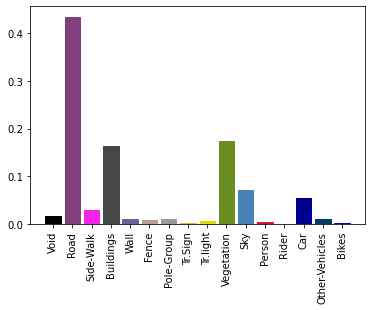

In [34]:

# labels={
# 0: "void",
# 1: "Drivable" ,
# 2: "Non-Drivable",
# 3: "Living-things",
# 4: "2-wheeler",
# 5: "autorickshaw",
# 6: "Car",
# 7: "Large-Vehicle",
# 8: "Barrier",
# 9: "Structures",
# 10: "Construction",
# 11: "Vegetation",
# 12: "Sky"
# }
# color_map = {
#     0: [0, 0, 0],  # Void
#     1: [128, 64, 128],  # Drivable
#     2: [244, 35, 232],  # Non-drivable
#     3: [220, 20, 60],  # living Things
#     4: [0, 0, 230],  # 2 wheeler
#     5: [190, 153, 153],  # Rickshaw
#     6: [0, 0, 142],  # Car
#     7: [0, 60, 100],  # Large Vehicles
#     8: [220, 220, 0],  # Barriers
#     9: [153, 153, 153],  # Structures
#     10: [70, 70, 70],  # Construction
#     11: [107, 142, 35],  # Vegitation
#     12: [70, 130, 180],  # Sky
# }

"""
Version 2 
0: void: unlabeled/ego vehicle/ rectif. border/ out of roi /static/ dynamic/ ground
1: Road :  roadq/parking/rail track
2: S.Walk: Swalk
3: Build:building/bridge/tunnel
4: Wall: wall/ guard rail
5: Fence: fence
6: Pole: pole / pole group
7: Tr.Light: traffic light
8: Sign:  rtraffic sign
9: Veget.: Vegetation terrain
10: Sky: Sky 
11: Person:Person
12:Rider: rider
13: Car:car
14: Other vehicles: caravan/ trailer/ bus/ truck / train
15: M.Bike/Bike: motorcycle/ bicycle
"""
labels={
    0: "Void",
    1:"Road",
    2:"Side-Walk",
    3:"Buildings",
    4:"Wall",
    5:"Fence",
    6:"Pole-Group",
    7:"Tr.Sign",
    8:"Tr.light",
    9:"Vegetation",
    10:"Sky",
    11:"Person",
    12:"Rider",
    13:"Car",
    14:"Other-Vehicles",
    15:"Bikes",

}
color_map_v3_16C = {
    0: [0, 0, 0],  # Void
    1: [128, 64, 128],  # Road
    2: [244, 35, 232],  # Side Walk
    3: [70, 70, 70],  # Building
    4: [102, 102, 156],  # Wall
    5: [190, 153, 153],  # Fence
    6: [153, 153, 153],  # pole
    7: [250, 170, 30],  # traffic light
    8: [220, 220, 0],  # Traffic sign
    9: [107, 142, 35],  # Vegitation
    10: [70, 130, 180],  # sky
    11: [220, 20, 60],  # human
    12: [255, 0, 0],  # rider
    13: [0, 0, 142],  # car
    14: [0, 60, 100],  # other vehicles
    15: [0, 0, 230],  # bike and motorcycle
}
#ckpt= "/no_backups/g013/checkpoints/SSG_v3.13/ckpt/140000.pt"
# generated_class_dist = generate_model_dist_plot(ckpt,color_map_v3_16C,labels,samples=3_000,save_dir="./synthetic_results.png")

# lmdb_dataset="/no_backups/g013/data/lmdb_datasets/lmdb_v3.3"
# real_class_dist = generate_real_data_dist_plot(lmdb_dataset,color_map_v3_16C,labels,batch_size=8,save_dir="./real_classes_dist.png")
 

#### For Mapillary

In [ ]:

# labels={
# 0: "void",
# 1: "Drivable" ,
# 2: "Non-Drivable",
# 3: "Living-things",
# 4: "2-wheeler",
# 5: "autorickshaw",
# 6: "Car",
# 7: "Large-Vehicle",
# 8: "Barrier",
# 9: "Structures",
# 10: "Construction",
# 11: "Vegetation",
# 12: "Sky"
# }
# color_map = {
#     0: [0, 0, 0],  # Void
#     1: [128, 64, 128],  # Drivable
#     2: [244, 35, 232],  # Non-drivable
#     3: [220, 20, 60],  # living Things
#     4: [0, 0, 230],  # 2 wheeler
#     5: [190, 153, 153],  # Rickshaw
#     6: [0, 0, 142],  # Car
#     7: [0, 60, 100],  # Large Vehicles
#     8: [220, 220, 0],  # Barriers
#     9: [153, 153, 153],  # Structures
#     10: [70, 70, 70],  # Construction
#     11: [107, 142, 35],  # Vegitation
#     12: [70, 130, 180],  # Sky
# }

"""
Version 2 
0: void: unlabeled/ego vehicle/ rectif. border/ out of roi /static/ dynamic/ ground
1: Road :  roadq/parking/rail track
2: S.Walk: Swalk
3: Build:building/bridge/tunnel
4: Wall: wall/ guard rail
5: Fence: fence
6: Pole: pole / pole group
7: Tr.Light: traffic light
8: Sign:  rtraffic sign
9: Veget.: Vegetation terrain
10: Sky: Sky 
11: Person:Person
12:Rider: rider
13: Car:car
14: Other vehicles: caravan/ trailer/ bus/ truck / train
15: M.Bike/Bike: motorcycle/ bicycle
"""
labels={
    0: "Void",
    1:"Road",
    2:"Side-Walk",
    3:"Buildings",
    4:"Wall",
    5:"Fence",
    6:"Pole-Group",
    7:"Tr.Sign",
    8:"Tr.light",
    9:"Vegetation",
    10:"Sky",
    11:"Person",
    12:"Rider",
    13:"Car",
    14:"Other-Vehicles",
    15:"Bikes",

}

color_map_v3_16C = {
    0: [0, 0, 0],  # Void
    1: [128, 64, 128],  # Road
    2: [244, 35, 232],  # Side Walk
    3: [70, 70, 70],  # Building
    4: [102, 102, 156],  # Wall
    5: [190, 153, 153],  # Fence
    6: [153, 153, 153],  # pole
    7: [250, 170, 30],  # traffic light
    8: [220, 220, 0],  # Traffic sign
    9: [107, 142, 35],  # Vegitation
    10: [70, 130, 180],  # sky
    11: [220, 20, 60],  # human
    12: [255, 0, 0],  # rider
    13: [0, 0, 142],  # car
    14: [0, 60, 100],  # other vehicles
    15: [0, 0, 230],  # bike and motorcycle
}
ckpt= "/no_backups/g013/checkpoints/mapillary_v1/ckpt/250000.pt"
generated_class_dist = generate_model_dist_plot(ckpt,color_map_v3_16C,labels,samples=3_000,save_dir="./synthetic_results.png")

# lmdb_dataset="/no_backups/g013/data/lmdb_datasets/lmdb_v3.3"
# real_class_dist = generate_real_data_dist_plot(lmdb_dataset,color_map_v3_16C,labels,batch_size=8,save_dir="./real_classes_dist.png")
 